In [1]:
!pip install -q torch torchvision torch-geometric mediapipe==0.10.14 opencv-python scipy numpy matplotlib pandas scikit-learn tensorboard tqdm

import torch
print(f"GPU Available: {torch.cuda.is_available()}")
print(f"GPU Name: {torch.cuda.get_device_name() if torch.cuda.is_available() else 'CPU'}")



GPU Available: True
GPU Name: Tesla T4


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import mediapipe as mp
import cv2
from pathlib import Path
from typing import Tuple, Dict, List, Optional
import scipy.signal as signal
from scipy.fftpack import fft, fftfreq
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import warnings
warnings.filterwarnings('ignore')


In [9]:
!pip install -q protobuf==4.25.3 mediapipe==0.10.14


In [2]:
import mediapipe as mp
print("MediaPipe OK:", mp.__version__)

# quick sanity test
mp.solutions.pose.Pose()
print("Pose loaded successfully")


MediaPipe OK: 0.10.14
Pose loaded successfully


In [4]:
!pip install -q torch torchvision torch-geometric mediapipe==0.10.14 opencv-python scipy numpy matplotlib pandas scikit-learn tensorboard tqdm


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import mediapipe as mp
import cv2
from pathlib import Path
from typing import Tuple, Dict, List, Optional
import scipy.signal as signal
from scipy.fftpack import fft, fftfreq
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import warnings
warnings.filterwarnings('ignore')


MiniMeshPhys: UBFC Facial rPPG Evaluation

Device: cuda

Model created with 220778 parameters

Loading UBFC video and ground truth BVP...
Processing video: /content/ubfc_video.mp4
Total frames: 450, FPS: 30.0
Using max 450 frames
  Processed 30 frames
  Processed 60 frames
  Processed 90 frames
  Processed 120 frames
  Processed 150 frames
  Processed 180 frames
  Processed 210 frames
  Processed 240 frames
  Processed 270 frames
  Processed 300 frames
  Processed 330 frames
  Processed 360 frames
  Processed 390 frames
  Processed 420 frames
  Processed 450 frames
Built STGraph: torch.Size([450, 468, 3])
Frames used: 450
Video FPS: 30.0
Loaded BVP samples: 450

Training MiniMeshPhys on UBFC data...
Epoch  10 | Loss: 0.7050 | Pred HR: 56.0 BPM, GT HR: 56.0 BPM
Epoch  20 | Loss: 0.7256 | Pred HR: 56.0 BPM, GT HR: 56.0 BPM
Epoch  30 | Loss: 0.5436 | Pred HR: 56.0 BPM, GT HR: 56.0 BPM
Epoch  40 | Loss: 0.5188 | Pred HR: 56.0 BPM, GT HR: 56.0 BPM
Epoch  50 | Loss: 0.5048 | Pred HR: 52.0 BP

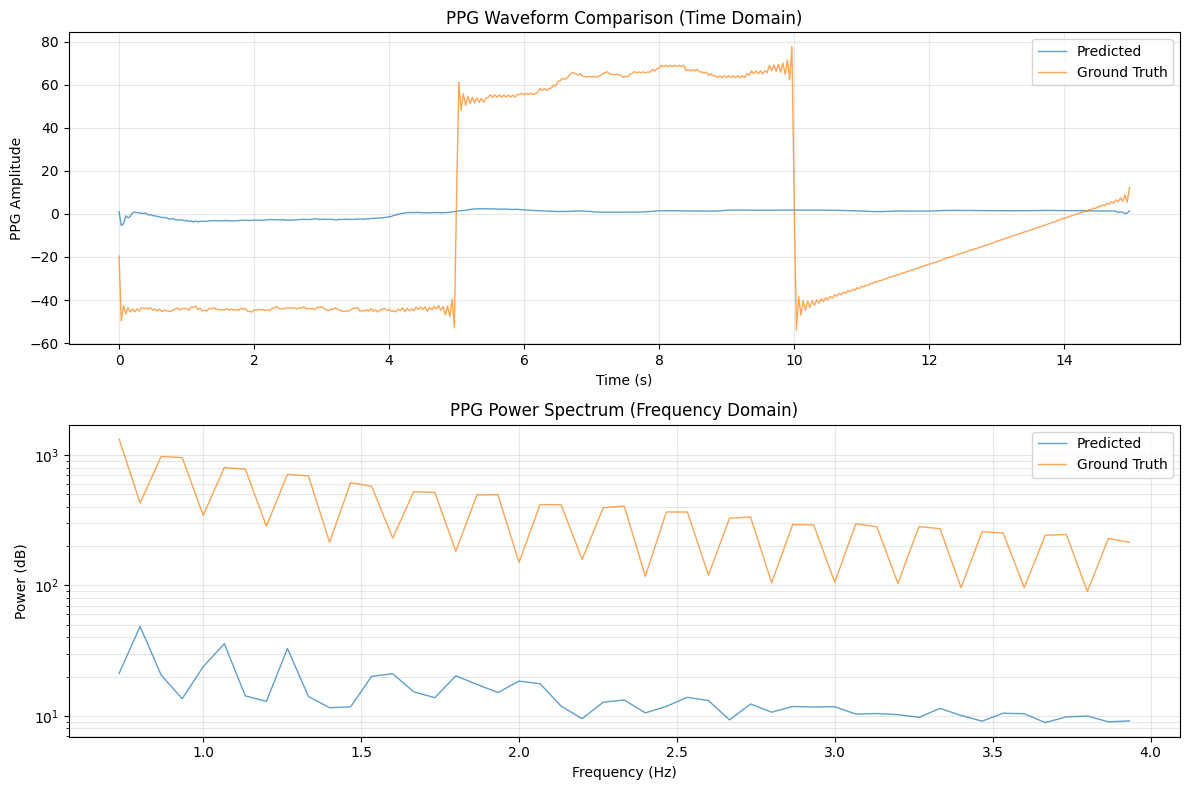

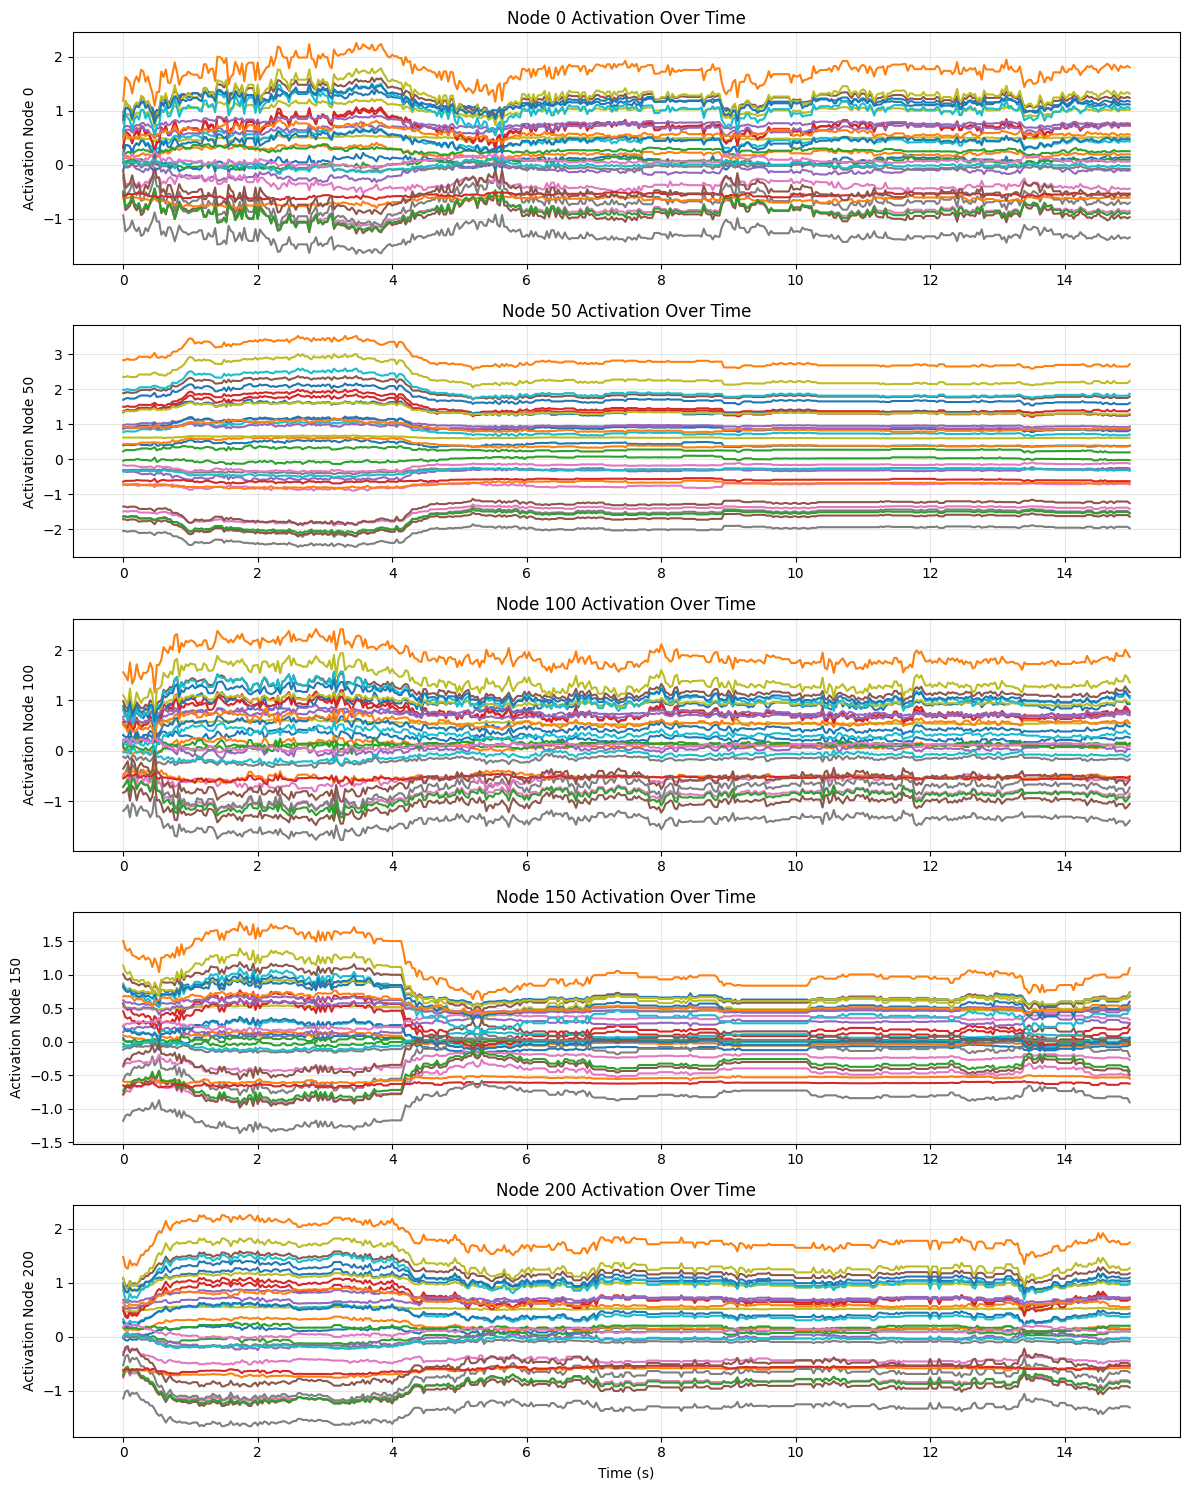


UBFC evaluation complete!


In [13]:
"""
MiniMeshPhys: Lightweight implementation of facial rPPG using Graph Neural Networks
Demonstrates the key concepts from the MeshPhys paper with simplified architecture.

Author: rPPG Implementation
Date: 2026
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
from pathlib import Path
from typing import Tuple, Dict, List, Optional
import scipy.signal as signal
from scipy.fftpack import fft, fftfreq
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# 1. SPATIOTEMPORAL GRAPH CONSTRUCTION
# ============================================================================
class STGraphBuilder:
    """
    Builds Spatiotemporal Graphs from facial video.
    Encodes facial surface appearance and topology over time.
    """

    def __init__(self, use_mediapipe: bool = True):
        self.use_mediapipe = use_mediapipe

        if use_mediapipe:
            self.mp_face_mesh = mp.solutions.face_mesh.FaceMesh(
                static_image_mode=False,
                max_num_faces=1,
                min_detection_confidence=0.5,
                min_tracking_confidence=0.5
            )
            # MediaPipe gives 468 landmarks
            self.num_nodes = 468
        else:
            self.num_nodes = 852

    def get_3d_mesh(self, frame: np.ndarray) -> Optional[np.ndarray]:
        """Extract 3D facial mesh from frame."""
        if not self.use_mediapipe:
            return None

        results = self.mp_face_mesh.process(
            cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        )

        if not results.multi_face_landmarks:
            return None

        landmarks = results.multi_face_landmarks[0]
        mesh_3d = np.array([[lm.x, lm.y, lm.z] for lm in landmarks.landmark])
        return mesh_3d

    def extract_node_features(self, frame: np.ndarray,
                              mesh_3d: np.ndarray) -> np.ndarray:
        """Extract RGB values at landmark locations."""
        h, w, _ = frame.shape
        node_features = []

        for x, y, _ in mesh_3d:
            px = int(x * w)
            py = int(y * h)

            px = np.clip(px, 0, w - 1)
            py = np.clip(py, 0, h - 1)

            rgb = frame[py, px, ::-1].astype(np.float32) / 255.0
            node_features.append(rgb)

        return np.array(node_features)

    def build_adjacency_matrix(self, mesh_3d: np.ndarray,
                               distance_threshold: float = 0.15) -> torch.Tensor:
        """Build adjacency based on 3D landmark proximity."""
        num_nodes = len(mesh_3d)
        adjacency = np.zeros((num_nodes, num_nodes), dtype=np.float32)

        for i in range(num_nodes):
            for j in range(i + 1, num_nodes):
                if np.linalg.norm(mesh_3d[i] - mesh_3d[j]) < distance_threshold:
                    adjacency[i, j] = 1.0
                    adjacency[j, i] = 1.0

        np.fill_diagonal(adjacency, 1.0)
        return torch.from_numpy(adjacency)

    def build_stgraph(self,
                      video_path: str,
                      skip_frames: int = 1,
                      normalize: bool = True,
                      max_frames: int = 450) -> Dict:
        """
        Build Spatiotemporal Graph from input video.
        Video is trimmed to max_frames.
        """

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError(f"Cannot open video: {video_path}")

        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        print(f"Processing video: {video_path}")
        print(f"Total frames: {total_frames}, FPS: {fps}")
        print(f"Using max {max_frames} frames")

        node_features_list = []
        adjacency = None
        frame_count = 0

        while frame_count < max_frames:
            ret, frame = cap.read()
            if not ret:
                break

            if frame_count % skip_frames != 0:
                frame_count += 1
                continue

            mesh_3d = self.get_3d_mesh(frame)
            if mesh_3d is None:
                frame_count += 1
                continue

            node_features = self.extract_node_features(frame, mesh_3d)
            node_features_list.append(node_features)

            if adjacency is None:
                adjacency = self.build_adjacency_matrix(mesh_3d)

            if len(node_features_list) % 30 == 0:
                print(f"  Processed {len(node_features_list)} frames")

            frame_count += 1

        cap.release()

        if not node_features_list:
            raise ValueError("No frames processed, face not detected")

        node_features = torch.from_numpy(
            np.array(node_features_list)
        ).float()

        if normalize:
            mean = node_features.mean(dim=(0, 1), keepdim=True)
            std = node_features.std(dim=(0, 1), keepdim=True)
            node_features = (node_features - mean) / (std + 1e-5)

        print(f"Built STGraph: {node_features.shape}")

        return {
            'node_features': node_features,
            'adjacency': adjacency,
            'fps': fps,
            'num_frames': node_features.shape[0]
        }




# ============================================================================
# 2. GRAPH NEURAL NETWORK MODEL
# ============================================================================

class MultiKernelTemporalConv(nn.Module):
    """Multi-kernel temporal convolution for adaptive temporal modeling.

    Input:  x  [T, N, C_in]  (time, nodes, channels)
    Output: out [T, N, C_out]
    """
    def __init__(self, in_channels: int, out_channels: int,
                 kernels: List[int] = [3, 5, 9]):
        super().__init__()
        self.kernels = kernels
        self.out_channels = out_channels

        # Parallel temporal convolutions over time dimension
        # Conv1d expects [batch, channels, time] → we use batch = nodes
        self.temp_convs = nn.ModuleList([
            nn.Conv1d(in_channels, out_channels, kernel,
                      padding=kernel // 2, bias=True)
            for kernel in kernels
        ])

        # Gating mechanism: combines K kernel branches into one
        # Input:  [N, C_out * K] (after global pooling)
        # Output: [N, K] (kernel weights per node)
        self.gating_mlp = nn.Sequential(
            nn.Linear(out_channels * len(kernels), out_channels),
            nn.ReLU(inplace=True),
            nn.Linear(out_channels, len(kernels)),
            nn.Softmax(dim=1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: [T, N, C_in] node features

        Returns:
            [T, N, C_out] fused temporal features
        """
        T, N, C = x.shape                         # [T, N, C_in]
        # Conv1d over time: [N, C_in, T]
        x_perm = x.permute(1, 2, 0)               # [N, C_in, T]

        # Apply parallel temporal convolutions
        branch_outputs = []
        for conv in self.temp_convs:
            out = conv(x_perm)                    # [N, C_out, T]
            branch_outputs.append(out)

        # Stack along new branch dimension: [N, K, C_out, T]
        stacked = torch.stack(branch_outputs, dim=1)

        # For gating, first concatenate along channel dim: [N, C_out*K, T]
        combined = torch.cat(branch_outputs, dim=1)        # [N, C_out*K, T]
        pooled = combined.mean(dim=2)                      # [N, C_out*K]

        # Compute kernel weights per node: [N, K]
        gates = self.gating_mlp(pooled)                    # [N, K]
        gates = gates.view(N, self.kernels.__len__(), 1, 1)  # [N, K, 1, 1]

        # Apply gating and sum over kernels
        gated = (stacked * gates).sum(dim=1)               # [N, C_out, T]

        # Back to [T, N, C_out]
        out = gated.permute(2, 0, 1)                       # [T, N, C_out]
        return out


class MiniMeshPhys(nn.Module):
    """
    Lightweight spatiotemporal graph convolutional network for facial rPPG.

    Architecture:
    - Multi-kernel temporal convolutions (adaptive temporal patterns)
    - Spatial graph convolutions (surface-aligned modeling)
    - Progressive spatial pooling (efficient computation)
    - Linear prediction head (waveform estimation)
    """

    def __init__(self, num_nodes: int = 468, hidden_dim: int = 32,
                 depth: int = 3, kernels: List[int] = [3, 5, 9]):
        super().__init__()
        self.num_nodes = num_nodes
        self.hidden_dim = hidden_dim

        # Initial projection
        self.input_proj = nn.Linear(3, hidden_dim)

        # Spatiotemporal blocks
        self.layers = nn.ModuleList()
        for i in range(depth):
            in_ch = hidden_dim if i == 0 else hidden_dim * (i)
            out_ch = hidden_dim * (i + 1)

            self.layers.append(nn.ModuleDict({
                'mktc': MultiKernelTemporalConv(in_ch, out_ch, kernels),
                'gcn': GCNConv(out_ch, out_ch),
                'norm': nn.BatchNorm1d(out_ch)
            }))

        # Output projection to waveform
        final_dim = hidden_dim * depth
        self.waveform_head = nn.Sequential(
            nn.Linear(final_dim, final_dim // 2),
            nn.ReLU(),
            nn.Linear(final_dim // 2, 1)
        )

    def forward(self, node_features: torch.Tensor,
                edge_index: torch.Tensor) -> torch.Tensor:
        """
        Args:
            node_features: [T, N, 3] RGB values
            edge_index: [2, E] edge indices

        Returns:
            waveform: [T] predicted PPG signal
        """
        T, N, _ = node_features.shape

        # Project input
        x = self.input_proj(node_features)  # [T, N, hidden_dim]

        # Spatiotemporal processing
        for layer in self.layers:
            # Temporal convolution
            x_temporal = layer['mktc'](x)  # [T, N, C]

            # Spatial convolution per timeframe
            x_spatial_list = []
            for t in range(T):
                x_t = x_temporal[t]  # [N, C]
                x_t = layer['gcn'](x_t, edge_index)  # [N, C]
                x_t = layer['norm'](x_t)  # [N, C]
                x_t = F.relu(x_t)
                x_spatial_list.append(x_t)

            x = torch.stack(x_spatial_list, dim=0)  # [T, N, C]

        # Global average pooling
        x = x.mean(dim=1)  # [T, C]

        # Predict waveform
        waveform = self.waveform_head(x).squeeze(-1)  # [T]

        return waveform


# ============================================================================
# 3. DATASET HANDLING
# ============================================================================

class rPPGDataset:
    """
    rPPG dataset handler for UBFC-style data.
    Loads video and Raw BVP (Blood Volume Pulse) ground truth from text file.
    """

    def __init__(self, video_path: str, ppg_path: Optional[str] = None):
        self.video_path = video_path
        self.ppg_path = ppg_path
        self.stgraph_builder = STGraphBuilder()

    def load_ppg_ground_truth(self,
                              num_frames: Optional[int] = None) -> Optional[np.ndarray]:
        """
        Load Raw BVP ground truth from UBFC text file.
        Supports: .txt, .csv, .npy

        Args:
            num_frames: if provided, resample BVP to match video frame count

        Returns:
            1D numpy array of BVP values
        """
        if self.ppg_path is None:
            return None

        path = Path(self.ppg_path)
        if not path.exists():
            return None

        bvp = None

        # NPY
        if path.suffix == ".npy":
            bvp = np.load(path).flatten()

        # TXT / CSV (UBFC style)
        elif path.suffix in [".txt", ".csv"]:
            values = []
            with open(path, "r") as f:
                for v in f.read().replace(",", " ").split():
                    try:
                        values.append(float(v))
                    except ValueError:
                        continue
            if values:
                bvp = np.array(values, dtype=np.float32)

        if bvp is None or len(bvp) == 0:
            return None

        # Resample BVP to match video length
        if num_frames is not None and len(bvp) != num_frames:
            bvp = signal.resample(bvp, num_frames)
        bvp = bvp - np.mean(bvp)
        bvp = bvp.astype(np.float32)
        return bvp.astype(np.float32)

    def get_stgraph(self, max_frames: int = 450) -> Dict:
        """
        Build spatiotemporal graph from input video.
        Video is trimmed to max_frames.
        """
        return self.stgraph_builder.build_stgraph(
            self.video_path,
            max_frames=max_frames
        )

    @staticmethod
    def create_dummy_ppg(num_frames: int,
                         fps: float,
                         heart_rate: float = 70.0) -> np.ndarray:
        """
        Create synthetic PPG signal (kept for debugging only).
        """
        t = np.arange(num_frames) / fps
        freq = heart_rate / 60.0
        ppg = np.sin(2 * np.pi * freq * t)
        ppg += 0.1 * np.random.randn(num_frames)
        return ppg

# ============================================================================
# 4. LOSS FUNCTIONS
# ============================================================================

class rPPGLosses:
    """
    Losses for rPPG training based on MeshPhys paper.
    """

    @staticmethod
    def morphological_correlation(pred: torch.Tensor,
                                 target: torch.Tensor) -> torch.Tensor:
        """
        Pearson correlation loss.
        Captures morphological similarity regardless of scale.
        """
        pred = pred - pred.mean()
        target = target - target.mean()

        numerator = (pred * target).sum()
        denominator = torch.sqrt((pred ** 2).sum() * (target ** 2).sum())

        correlation = numerator / (denominator + 1e-7)
        return 1.0 - correlation

    @staticmethod
    def temporal_derivative_loss(pred: torch.Tensor,
                                target: torch.Tensor) -> torch.Tensor:
        """
        First-order derivative correlation.
        Captures temporal dynamics.
        """
        pred_diff = pred[1:] - pred[:-1]
        target_diff = target[1:] - target[:-1]
        return rPPGLosses.morphological_correlation(pred_diff, target_diff)

    @staticmethod
    def phase_shift_robust_loss(pred: torch.Tensor,
                               target: torch.Tensor,
                               max_shift: int = 50,
                               beta: float = 10.0) -> torch.Tensor:
        """
        Loss that handles phase shifts between video and PPG.
        Averages over circular shifts.
        """
        min_loss = float('inf')

        for shift in range(-max_shift, max_shift):
            if shift > 0:
                pred_shifted = pred[shift:]
                target_shifted = target[:-shift]
            elif shift < 0:
                pred_shifted = pred[:shift]
                target_shifted = target[-shift:]
            else:
                pred_shifted = pred
                target_shifted = target

            if len(pred_shifted) == 0:
                continue

            loss = rPPGLosses.morphological_correlation(pred_shifted, target_shifted)
            min_loss = min(min_loss.item() if isinstance(min_loss, torch.Tensor) else min_loss,
                          loss.item())

        return torch.tensor(min_loss, device=pred.device, dtype=pred.dtype)

    @staticmethod
    def composite_loss(pred: torch.Tensor, target: torch.Tensor,
                      use_phase_shift: bool = False) -> torch.Tensor:
        """
        Combined loss from MeshPhys paper.
        """
        l_corr = rPPGLosses.morphological_correlation(pred, target)
        l_diff = rPPGLosses.temporal_derivative_loss(pred, target)

        loss = l_corr + 0.5 * l_diff

        if use_phase_shift:
            l_phase = rPPGLosses.phase_shift_robust_loss(pred, target)
            loss += 0.1 * l_phase

        return loss


# ============================================================================
# 5. SIGNAL PROCESSING
# ============================================================================

class SignalProcessor:
    """
    Processing and analysis of PPG / BVP signals.

    Assumes:
    - Signal is already resampled to video FPS
    - One sample per video frame
    """

    @staticmethod
    def extract_heart_rate(signal_data: np.ndarray,
                           fps: float,
                           band: Tuple[float, float] = (0.7, 4.0)) -> float:
        """
        Extract heart rate (BPM) from PPG/BVP using frequency-domain analysis.
        """

        if signal_data is None or len(signal_data) < int(3 * fps):
            return float("nan")

        # Remove DC component
        signal_data = signal_data - np.mean(signal_data)

        # Normalized band limits (Nyquist-safe)
        low = band[0] / (fps / 2)
        high = band[1] / (fps / 2)
        high = min(high, 0.99)

        # Band-pass filter
        sos = signal.butter(
            4, [low, high],
            btype="band",
            output="sos"
        )
        filtered = signal.sosfiltfilt(sos, signal_data)

        # Windowing to reduce spectral leakage
        windowed = filtered * np.hanning(len(filtered))

        # One-sided FFT → Power spectrum
        fft_vals = np.abs(np.fft.rfft(windowed))
        psd = fft_vals ** 2
        freqs = np.fft.rfftfreq(len(windowed), d=1.0 / fps)

        # Physiological frequency mask
        mask = (freqs >= band[0]) & (freqs <= band[1])
        if not np.any(mask):
            return float("nan")

        # Dominant frequency
        dominant_freq = freqs[mask][np.argmax(psd[mask])]

        return float(dominant_freq * 60.0)

    @staticmethod
    def snr_weighting(signal_data: np.ndarray,
                      fps: float,
                      heart_rate: float) -> float:
        """
        Approximate SNR around heart-rate frequency.
        Used for reliability weighting.
        """

        if signal_data is None or len(signal_data) < int(3 * fps):
            return 0.1

        signal_data = signal_data - np.mean(signal_data)

        low = 0.7 / (fps / 2)
        high = min(4.0 / (fps / 2), 0.99)

        sos = signal.butter(
            4, [low, high],
            btype="band",
            output="sos"
        )
        filtered = signal.sosfiltfilt(sos, signal_data)

        windowed = filtered * np.hanning(len(filtered))
        psd = np.abs(np.fft.rfft(windowed)) ** 2
        freqs = np.fft.rfftfreq(len(windowed), d=1.0 / fps)

        hr_hz = heart_rate / 60.0
        signal_band = (freqs >= hr_hz - 0.5) & (freqs <= hr_hz + 0.5)

        signal_power = psd[signal_band].sum()
        total_power = psd.sum() + 1e-8

        snr = signal_power / total_power
        return float(np.clip(snr, 0.1, 1.0))



# ============================================================================
# 6. TRAINING PIPELINE
# ============================================================================

class Trainer:
    """Training loop for MiniMeshPhys."""

    def __init__(self, model: nn.Module, device: str = 'cuda'):
        self.model = model.to(device)
        self.device = device
        self.optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
        self.history = {'loss': [], 'hr_error': []}

    def train_step(self, node_features: torch.Tensor,
                  edge_index: torch.Tensor,
                  ppg_ground_truth: torch.Tensor) -> float:
        """Single training step."""
        self.optimizer.zero_grad()

        # Forward pass
        pred_waveform = self.model(node_features, edge_index)

        # Loss
        loss = rPPGLosses.composite_loss(pred_waveform, ppg_ground_truth,
                                        use_phase_shift=False)

        # Backward
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        self.optimizer.step()

        return loss.item()

    def train_epoch(self, dataset: rPPGDataset, num_epochs: int = 50):
        """Train for multiple epochs."""
        self.model.train()

        # Get data
        stgraph = dataset.get_stgraph()
        node_features = stgraph['node_features'].to(self.device)
        adjacency = stgraph['adjacency'].to(self.device)
        fps = stgraph['fps']

        # Get or create ground truth
        ppg_gt = dataset.load_ppg_ground_truth()
        if ppg_gt is None:
            raise FileNotFoundError(
        "Ground truth BVP file could not be loaded. "
        "Provide a valid UBFC Raw BVP text file."
    )

        ppg_gt = torch.from_numpy(ppg_gt[:node_features.shape[0]]).float().to(self.device)

        # Convert adjacency to edge_index
        edge_index = adjacency.nonzero(as_tuple=True)
        edge_index = torch.stack(edge_index).to(self.device)

        # Training loop
        print("\nTraining MiniMeshPhys")
        print("-" * 50)
        for epoch in range(num_epochs):
            loss = self.train_step(node_features, edge_index, ppg_gt)

            # Extract heart rate
            with torch.no_grad():
                pred_waveform = self.model(node_features, edge_index)
                pred_ppg = pred_waveform.cpu().numpy()

            pred_hr = SignalProcessor.extract_heart_rate(pred_ppg, fps)
            gt_hr = SignalProcessor.extract_heart_rate(ppg_gt.cpu().numpy(), fps)
            hr_error = abs(pred_hr - gt_hr)

            self.history['loss'].append(loss)
            self.history['hr_error'].append(hr_error)

            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1:3d} | Loss: {loss:.4f} | HR Error: {hr_error:.2f} BPM "
                      f"(Pred: {pred_hr:.1f}, GT: {gt_hr:.1f})")

        print("-" * 50)
        return node_features, edge_index, ppg_gt

    def save(self, path: str):
        """Save model checkpoint."""
        torch.save({
            'model_state': self.model.state_dict(),
            'history': self.history
        }, path)
        print(f"Model saved to {path}")

    def load(self, path: str):
        """Load model checkpoint."""
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state'])
        self.history = checkpoint['history']
        print(f"Model loaded from {path}")


# ============================================================================
# 7. INFERENCE & VISUALIZATION
# ============================================================================

class Visualizer:
    """Visualization utilities."""

    @staticmethod
    def plot_training_history(history: Dict, save_path: Optional[str] = None):
        """Plot training metrics."""
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Loss
        axes[0].plot(history['loss'], label='Correlation Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Training Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # HR Error
        axes[1].plot(history['hr_error'], label='Heart Rate Error')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('HR Error (BPM)')
        axes[1].set_title('Heart Rate Estimation Error')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=100, bbox_inches='tight')
            print(f"Figure saved to {save_path}")
        plt.show()

    @staticmethod
    def plot_waveform_comparison(pred_waveform: np.ndarray,
                                 gt_waveform: np.ndarray,
                                 fps: float,
                                 save_path: Optional[str] = None):
        """Compare predicted vs ground truth PPG."""
        time = np.arange(len(pred_waveform)) / fps

        fig, axes = plt.subplots(2, 1, figsize=(12, 8))

        # Time domain
        axes[0].plot(time, pred_waveform, label='Predicted', alpha=0.7, linewidth=1)
        axes[0].plot(time, gt_waveform, label='Ground Truth', alpha=0.7, linewidth=1)
        axes[0].set_xlabel('Time (s)')
        axes[0].set_ylabel('PPG Amplitude')
        axes[0].set_title('PPG Waveform Comparison (Time Domain)')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Frequency domain
        pred_fft = np.abs(fft(pred_waveform))
        gt_fft = np.abs(fft(gt_waveform))
        freqs = fftfreq(len(pred_waveform), 1 / fps)

        # Only show physiological range (0.7 - 4 Hz)
        mask = (freqs > 0.7) & (freqs < 4.0)

        axes[1].semilogy(freqs[mask], pred_fft[mask], label='Predicted', alpha=0.7, linewidth=1)
        axes[1].semilogy(freqs[mask], gt_fft[mask], label='Ground Truth', alpha=0.7, linewidth=1)
        axes[1].set_xlabel('Frequency (Hz)')
        axes[1].set_ylabel('Power (dB)')
        axes[1].set_title('PPG Power Spectrum (Frequency Domain)')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3, which='both')

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=100, bbox_inches='tight')
            print(f"Figure saved to {save_path}")
        plt.show()

    @staticmethod
    def plot_activation_maps(node_features: torch.Tensor,
                             model: nn.Module,
                             edge_index: torch.Tensor,
                             fps: float,
                             save_path: Optional[str] = None):
        """
        Visualize node activations over time.
        Shows which facial regions are important for rPPG.
        """
        # ✅ ensure everything is on the same device as the model
        device = next(model.parameters()).device
        node_features = node_features.to(device)
        edge_index = edge_index.to(device)

        model.eval()
        with torch.no_grad():
            # Sample some nodes (can't visualize all 468)
            sample_nodes = [0, 50, 100, 150, 200]
            sample_node_features = node_features[:, sample_nodes, :]  # kept if you later use it

            # Reconstruct intermediate activations
            x = model.input_proj(node_features)  # x: [T, N, C]

            fig, axes = plt.subplots(len(sample_nodes), 1,
                                     figsize=(12, 3 * len(sample_nodes)))
            if len(sample_nodes) == 1:
                axes = [axes]

            time = np.arange(x.shape[0]) / fps

            for idx, node_id in enumerate(sample_nodes):
                # Get activations for this node across time
                activations = x[:, node_id, :].detach().cpu().numpy()

                axes[idx].plot(time, activations)
                axes[idx].set_ylabel(f'Activation Node {node_id}')
                axes[idx].set_title(f'Node {node_id} Activation Over Time')
                axes[idx].grid(True, alpha=0.3)

                if idx < len(sample_nodes) - 1:
                    axes[idx].set_xlabel('')

            axes[-1].set_xlabel('Time (s)')

            plt.tight_layout()
            if save_path:
                plt.savefig(save_path, dpi=100, bbox_inches='tight')
                print(f"Figure saved to {save_path}")
            plt.show()


# ============================================================================
# 8. MAIN EXECUTION
# ============================================================================


def main():
    """UBFC evaluation pipeline using real video and Raw BVP ground truth"""

    print("=" * 70)
    print("MiniMeshPhys: UBFC Facial rPPG Evaluation")
    print("=" * 70)

    # ================= USER PATHS =================
    VIDEO_PATH = "/content/ubfc_video.mp4"   # <-- change this
    BVP_PATH = "/content/ground_truth.txt"       # <-- change this
    MAX_FRAMES = 450

    EPOCHS = 50
    # =============================================

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"\nDevice: {device}")

    # Create model
    model = MiniMeshPhys(num_nodes=468, hidden_dim=32, depth=3).to(device)
    print(f"\nModel created with {sum(p.numel() for p in model.parameters())} parameters")

    # Dataset (real UBFC input)
    print("\n" + "=" * 70)
    print("Loading UBFC video and ground truth BVP...")
    print("=" * 70)

    dataset = rPPGDataset(
        video_path=VIDEO_PATH,
        ppg_path=BVP_PATH,

    )

    # Build STGraph from input video (face detected here)
    stgraph = dataset.get_stgraph(max_frames=MAX_FRAMES)

    node_features = stgraph['node_features'].to(device)
    adjacency = stgraph['adjacency'].to(device)
    fps = stgraph['fps']
    num_frames = stgraph['num_frames']

    print(f"Frames used: {num_frames}")
    print(f"Video FPS: {fps}")

    # Load real BVP (no synthetic fallback)
    ppg_gt = dataset.load_ppg_ground_truth(num_frames=num_frames)

    if ppg_gt is None:
        raise FileNotFoundError(
            "Failed to load Raw BVP ground truth file. "
            "Provide a valid UBFC text file."
        )

    ppg_gt = torch.from_numpy(ppg_gt[:num_frames]).float().to(device)
    print(f"Loaded BVP samples: {len(ppg_gt)}")

    # Convert adjacency to edge_index
    edge_index = adjacency.nonzero(as_tuple=True)
    edge_index = torch.stack(edge_index).long().to(device)

    # ================= TRAINING =================
    print("\n" + "=" * 70)
    print("Training MiniMeshPhys on UBFC data...")
    print("=" * 70)

    trainer = Trainer(model, device=device)
    trainer.model.train()

    for epoch in range(EPOCHS):
        loss = trainer.train_step(node_features, edge_index, ppg_gt)

        if (epoch + 1) % 10 == 0:
            with torch.no_grad():
                pred = trainer.model(node_features, edge_index)
                pred_hr = SignalProcessor.extract_heart_rate(pred.cpu().numpy(), fps)
                gt_hr = SignalProcessor.extract_heart_rate(ppg_gt.cpu().numpy(), fps)

            print(
                f"Epoch {epoch+1:3d} | Loss: {loss:.4f} | "
                f"Pred HR: {pred_hr:.1f} BPM, GT HR: {gt_hr:.1f} BPM"
            )

    # ================= INFERENCE =================
    print("\n" + "=" * 70)
    print("Running inference...")
    print("=" * 70)

    trainer.model.eval()
    with torch.no_grad():
        pred_waveform = trainer.model(node_features, edge_index)
        pred_ppg = pred_waveform.cpu().numpy()

    pred_hr = SignalProcessor.extract_heart_rate(pred_ppg, fps)
    gt_hr = SignalProcessor.extract_heart_rate(ppg_gt.cpu().numpy(), fps)

    print("\nFinal Results:")
    print(f"  Predicted HR: {pred_hr:.2f} BPM")
    print(f"  Ground Truth HR: {gt_hr:.2f} BPM")
    print(f"  Error: {abs(pred_hr - gt_hr):.2f} BPM")

    # ================= VISUALIZATION =================
    print("\n" + "=" * 70)
    print("Generating visualizations...")
    print("=" * 70)

    Visualizer.plot_waveform_comparison(pred_ppg, ppg_gt.cpu().numpy(), fps)
    Visualizer.plot_activation_maps(node_features, model, edge_index, fps)

    print("\n" + "=" * 70)
    print("UBFC evaluation complete!")
    print("=" * 70)


if __name__ == '__main__':
    main()
